In [1]:
import tensorflow as tf
import keras

from keras import datasets, layers, models, utils

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

Loading Dataset

In [2]:
test_ds, test_dataset_info = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True, shuffle_files=True, split = 'train[70%:90%]')
train_ds, train_dataset_info = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True, shuffle_files=True, split = 'train[:70%]')

print("Train Split Length: {}".format(len(train_ds)))

print("Test Split Length: {}".format(len(test_ds)))




Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.483SYJ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Train Split Length: 16283
Test Split Length: 4653


Dataset Info

In [3]:
class_names = ['cat', 'dog']

BATCH_SIZE = 126

In [4]:
x_data = []
x_labels = []

for image, label in train_ds:
  #print(image.shape)
  x_data.append(tf.image.resize(image, [200, 200])/255)
  x_labels.append(label)
  #print(resized_images[0].shape)
  #break

x_data = np.array(x_data)
x_labels = np.array(x_labels)



In [5]:
y_data = []
y_labels = []

for image, label in test_ds:
  #print(image.shape)
  y_data.append(tf.image.resize(image, [200, 200])/255)
  y_labels.append(label)
  #break

y_data = np.array(y_data)
y_labels = np.array(y_labels)



Visualize Image

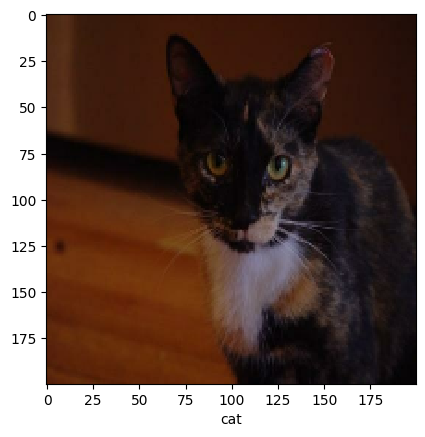

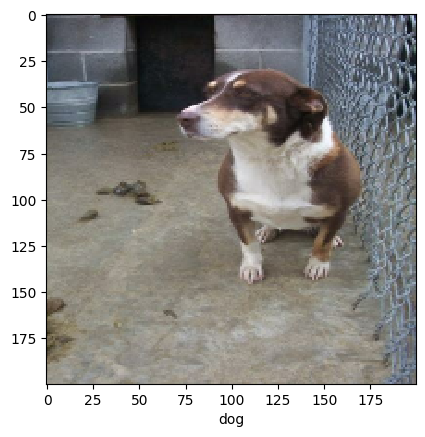

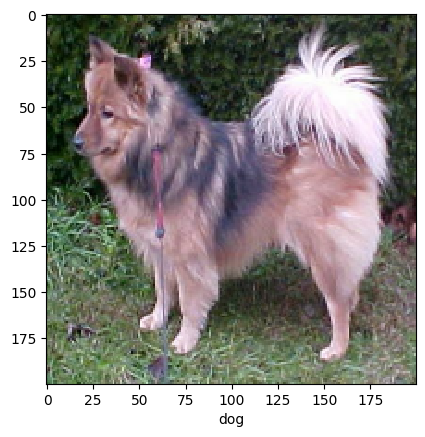

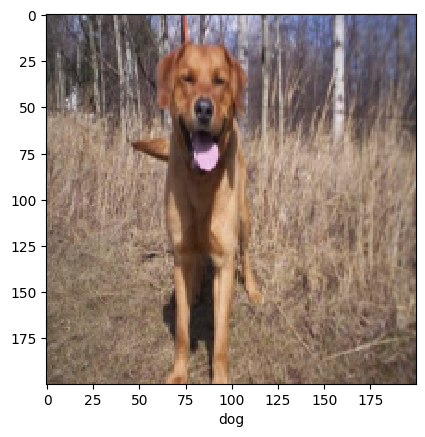

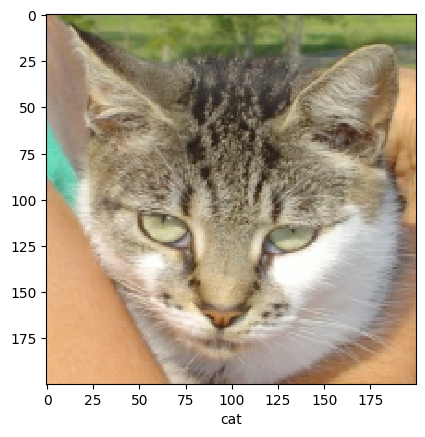

In [6]:
for i in range(5):
  plt.imshow(x_data[i], interpolation='nearest')
  plt.xlabel(class_names[x_labels[i]])
  plt.show()

  #print(image[0])




Test: Xception Model

In [ ]:
#Ensuring data is imported and preprocessed properly.

base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(200, 200, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = keras.layers.Input(shape=(200, 200, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(1)(x)

base_model = keras.Model(inputs, outputs)

base_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
base_model.fit(x_data, x_labels, epochs=1, batch_size = BATCH_SIZE)



130/130 [==============================] - 241s 2s/step - loss: 0.1336 - binary_accuracy: 0.9550


In [ ]:
test_loss, test_acc = base_model.evaluate(y_data, y_labels)

print("Test Accuracy: {}".format(test_acc))
print("Test Loss: {}".format(test_loss))

219/219 [==============================] - 82s 370ms/step - loss: 0.0515 - binary_accuracy: 0.9862
Test Accuracy: 0.9862444400787354
Test Loss: 0.05146939307451248


In [ ]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 20861480 (79.58 MB)
__________________

Custom CNN

In [7]:
model = models.Sequential()
model.add(layers.Input(shape = (200, 200, 3))),
model.add(layers.RandomFlip("horizontal_and_vertical")),
model.add(layers.RandomRotation(0.2)),
model.add(layers.Conv2D(32, (3, 3), activation='relu')),
model.add(layers.Conv2D(32, (3, 3), activation='relu')),
model.add(layers.MaxPooling2D(3, 3)),
model.add(layers.Dropout(0.2)),
model.add(layers.Conv2D(64, (3, 3), activation='relu')),
model.add(layers.Conv2D(64, (3, 3), activation='relu')),
model.add(layers.Flatten()),
model.add(keras.layers.BatchNormalization()),
model.add(layers.Dense((16), activation = 'relu')),
model.add(layers.Dense(2)),
model.add(keras.layers.BatchNormalization()),
model.add(keras.layers.Activation('sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 200, 200, 3)       0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 65, 65, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 65, 65, 32)        0

In [9]:
print("Shape of resized_images:", x_data.shape)
print("Shape of x_labels:", x_labels.shape)


print("Shape of resized_images:", y_data.shape)
print("Shape of y_labels:", y_labels.shape)

Shape of resized_images: (16283, 200, 200, 3)
Shape of x_labels: (16283,)
Shape of resized_images: (4653, 200, 200, 3)
Shape of y_labels: (4653,)


In [10]:
#model.compile(optimizer=keras.optimizers.Adam(),
#              loss=keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=[keras.metrics.BinaryAccuracy()])



model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy']) #crossentropy


#model.fit(x_data, x_labels, epochs=12, batch_size = BATCH_SIZE)

history = model.fit(x_data, x_labels, epochs=30, batch_size = BATCH_SIZE, validation_split = 0.2)



Epoch 1/30
104/104 [==============================] - 239s 2s/step - loss: 0.6506 - accuracy: 0.6087 - val_loss: 0.6742 - val_accuracy: 0.5149
Epoch 2/30
104/104 [==============================] - 237s 2s/step - loss: 0.5813 - accuracy: 0.6849 - val_loss: 0.6288 - val_accuracy: 0.7056
Epoch 3/30
104/104 [==============================] - 238s 2s/step - loss: 0.5629 - accuracy: 0.7063 - val_loss: 0.5813 - val_accuracy: 0.6859
Epoch 4/30
104/104 [==============================] - 238s 2s/step - loss: 0.5476 - accuracy: 0.7191 - val_loss: 0.5479 - val_accuracy: 0.7191
Epoch 5/30
104/104 [==============================] - 239s 2s/step - loss: 0.5305 - accuracy: 0.7317 - val_loss: 0.5451 - val_accuracy: 0.7102
Epoch 6/30
104/104 [==============================] - 239s 2s/step - loss: 0.5151 - accuracy: 0.7444 - val_loss: 0.6331 - val_accuracy: 0.6798
Epoch 7/30
104/104 [==============================] - 238s 2s/step - loss: 0.5066 - accuracy: 0.7475 - val_loss: 0.5126 - val_accuracy: 0.7498

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

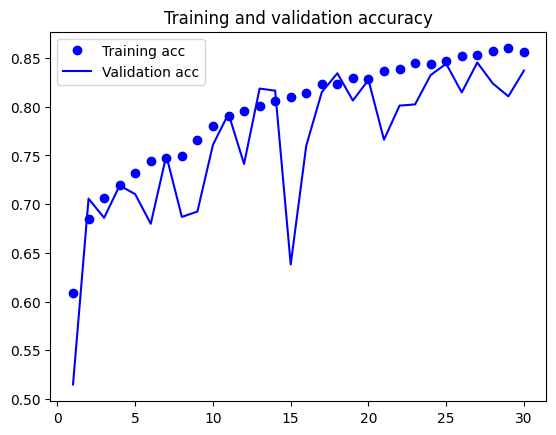

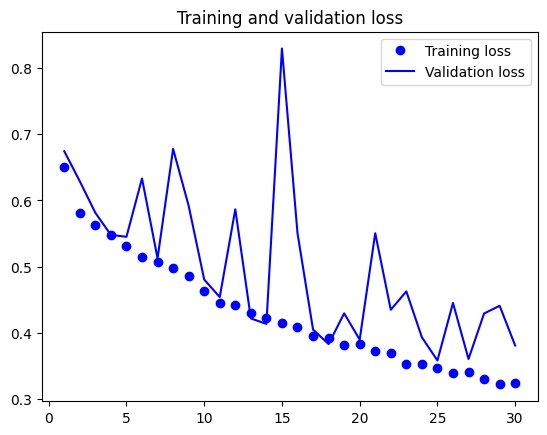

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
test_loss, test_acc = model.evaluate(y_data, y_labels)

print("Test Accuracy: {}".format(test_acc))
print("Test Loss: {}".format(test_loss))

146/146 [==============================] - 11s 74ms/step - loss: 0.3823 - accuracy: 0.8360
Test Accuracy: 0.83601975440979
Test Loss: 0.3823164105415344
